In [1]:
import os
import copy as cp
import sys
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch
import scipy.stats

In [2]:
sys.path.insert(1, '../code/')

from rank_functions import compute_mean_ranks, compute_transformed_Rmat
from rank_functions import transform_ranks, compute_rho_mat, compute_rank_sample
from plot_functions import compute_avg_mat
from format_helper_functions import find_mutation, make_aa_dict

In [3]:
# plotting settings
plt.rcParams.update({'font.size': 8})
plt.rcParams["font.family"] = 'Arial'
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "dejavusans"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Arial"] + plt.rcParams["font.serif"]
#plt.rcParams['axes.linewidth'] = .25 

# color maps
mymap = seaborn.diverging_palette(10, 300, s=60, as_cmap=True)
mycolors = seaborn.color_palette ('BrBG', 10)
mypinks  = seaborn.color_palette ('rocket', 10)
myspectral = seaborn.color_palette ('Spectral', 10)

In [4]:
# random number generator
myrng = np.random.default_rng (1)

In [5]:
wt_seq = 'QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE'

In [6]:
save       = True # saves plots to folder
large_file = False # does not require full set of simulated bootstrap samples

indir   = '../results/simulations/999/' # sigma = 2, 2-state model
protein = 'sim'
r = 5 # scaling factor for simulating read counts

# wild-type fitness
WT_inp = 1759616
WT_sel = 1471160
#WT_inp = 176403
#WT_sel = 147306
y_wt   = WT_sel / WT_inp

# observed wt fitness
WT_sel_obs = 3041819
y_wt_obs   = WT_sel_obs / WT_inp

# energies
ns    = 0.007
gb_wt = 1.3351635652561282
gf_wt = -7.305691319989728
lambda_wt = np.log ( np.exp (gb_wt) * (np.exp (gf_wt) + 1) )
print (lambda_wt)
p_wt      =  1 / (1. + np.exp (lambda_wt))

# make output director
outdir  = os.path.join (indir, 'plots')
if not os.path.isdir (outdir) :
    os.makedirs (outdir)

1.335835044751166


In [7]:
# double and single reads
n0_doubs = np.loadtxt ( os.path.join (indir, protein + '_D_neutral.txt'))
n1_doubs = np.loadtxt ( os.path.join (indir, protein + '_D_selection.txt') )
n0_sings = np.loadtxt ( os.path.join (indir, protein + '_S_neutral.txt'))
n1_sings = np.loadtxt ( os.path.join (indir, protein + '_S_selection.txt'))
c0_doubs = np.loadtxt ( os.path.join (indir, protein + '_D_C0.txt'))
c0_sings = np.loadtxt ( os.path.join (indir, protein + '_S_C0.txt'))

In [8]:
# observed phenotypes
y_sings_obs = np.loadtxt ( os.path.join (indir, 'gb1' + '_Y_singles.txt'))
y_doubs_obs = np.loadtxt ( os.path.join (indir, 'gb1' + '_Y_doubles.txt'))

In [9]:
# ordered energies
E  = np.loadtxt (os.path.join (indir, 'ordered_energies.txt'))
Pd = np.loadtxt (os.path.join (indir, 'p_doubles.txt'))

In [10]:
if large_file :
    # read in simulated Dmats
    Dsim = pickle.load ( open ( os.path.join (indir, protein + '_Dmats.pkl'), 'rb'))
    Dsim_unsorted = pickle.load (open (os.path.join (indir, 'sim_Dmats_unsorted.pkl'), 'rb'))

# simulated singles
ybs = pickle.load (open (os.path.join (indir, 'sim_SingleSimYs.pkl'), 'rb'))

In [11]:
# observed phenotypes and rank matrices
y_sings = np.loadtxt ( os.path.join (indir, protein + '_Y_singles.txt'))
y_doubs = np.loadtxt ( os.path.join (indir, protein + '_Y_doubles.txt'))
Rmat    = np.loadtxt ( os.path.join (indir, protein + '_Rmat.txt'))
Dmat    = np.loadtxt ( os.path.join (indir, protein + '_Dmat.txt'))
Dmat += np.transpose (Dmat)
bigImat = np.loadtxt ( os.path.join (indir, 'bigImat.txt'))
gamma_singles = np.loadtxt ( os.path.join (indir, 'sampled_single_lambdas.txt') )

# pvalues
Pvals = np.loadtxt ( os.path.join (indir, protein + '_P.txt') )

# distance matrix
Dist = np.loadtxt ('../data/GB1/GB1_distance_matrix.txt')
Df   = Dist[1:,1:]

# dimensions
L    = len (y_sings)
nAA  = 20
npos = int (L / nAA)

In [12]:
bigS  = np.reshape (np.repeat (gamma_singles, L), (L,L))
bigS += np.transpose (np.reshape (np.repeat (gamma_singles, L), (L,L)) )

# set values to missing along diagonal; wt should already be missing
for i in range (npos) :
    bigS[i*nAA:(i*nAA + nAA),:][:,i*nAA:(i*nAA + nAA)] = np.nan

#bigImat = (gamma_doubles - bigS)

In [13]:
rank_ys   = compute_mean_ranks (y_sings)
Rm        = compute_transformed_Rmat (n1_doubs / n0_doubs, M=np.nanmax (rank_ys))
rank_rbar = compute_mean_ranks (np.nanmean (Rm, axis=0))

/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_8476/3971163133.py:3: RuntimeWarning: Mean of empty slice
  rank_rbar = compute_mean_ranks (np.nanmean (Rm, axis=0))


In [14]:
not_wt = np.array ([x for x in range (L) if ~np.isnan (y_sings[x])], dtype=int)

In [15]:
# compute two-state energies for all variants
#egt = (np.exp (E[:,1] + gb_wt) * (np.exp (E[:,0] + gf_wt) + 1))
#gamma_singles     = (np.log (egt) - lambda_wt)      # effect sizes on gamme
gamma_singles_add = gamma_singles / 10# scale effect sizes for single mutants

In [16]:
# effects for doubles
bigS  = np.reshape (np.repeat ( gamma_singles_add, L), (L,L))
bigS += np.transpose (np.reshape (np.repeat (gamma_singles_add, L), (L,L)) )

# effects for doubles
bigS_therm  = np.reshape (np.repeat ( gamma_singles, L), (L,L))
bigS_therm += np.transpose (np.reshape (np.repeat (gamma_singles, L), (L,L)) )

# binding probability for singles + doubles doubles
p_singles = 1 / (1. + np.exp (gamma_singles + lambda_wt))
p_doubles = 1 / (1. + np.exp (bigS_therm + lambda_wt))
p_add_singles = np.exp (-(gamma_singles_add + lambda_wt))
p_add_doubles = np.exp (-(bigS + bigImat + lambda_wt))
p_wt_add = np.exp (-lambda_wt)

In [17]:
# double probabilities
p_tmp  = cp.deepcopy (p_add_doubles[np.triu_indices (L, k=1)])
c0_tmp = cp.deepcopy (c0_doubs[np.triu_indices (L, k=1)])
p_tmp[np.logical_or (np.isnan (p_tmp), np.isnan (c0_tmp))]  = 0
c0_tmp[np.logical_or (np.isnan (p_tmp), np.isnan (c0_tmp))] = 0

# single probabilities
c0s_tmp = cp.deepcopy (c0_sings)
ps_tmp  = cp.deepcopy (p_add_singles)
c0s_tmp[np.isnan (c0_sings)]     = 0
ps_tmp[np.isnan (p_add_singles)] = 0

# sample post-selection read counts
n1_sings_add = np.random.poisson ( c0s_tmp * ps_tmp * r )
n1_doubs_add = np.random.poisson ( c0_tmp * p_tmp * r )
n1_wt        = np.random.poisson ( WT_inp * p_wt_add * r )

# for therm model
p_tmp = cp.deepcopy (p_doubles[np.triu_indices (L, k=1)])
p_tmp[np.logical_or (np.isnan (p_tmp), np.isnan (c0_tmp))]  = 0
ps_tmp  = cp.deepcopy (p_singles)
ps_tmp[np.isnan (p_singles)] = 0

# sample reads
n1_sings_therm = np.random.poisson ( c0s_tmp * ps_tmp * r )
n1_doubs_therm = np.random.poisson ( c0_tmp * p_tmp * r )
n1_wt_therm    = np.random.poisson ( WT_inp * p_wt * r)

In [18]:
# find the estimated epistatic matrix 
ydoub_tmp = (n1_doubs_add + 1) / (n0_doubs[np.triu_indices (L, k=1)] + 1)
ydoub_add = np.zeros_like (y_doubs)
ydoub_add[np.triu_indices (L, k=1)] = cp.deepcopy (ydoub_tmp)
ydoub_add += np.transpose (ydoub_add)
ydoub_add[np.isnan (n0_doubs)] = np.nan
y_doubs_na = cp.deepcopy (ydoub_add)
y_doubs_na[ydoub_add == 0] = np.nan

# singles
ysing_add = (n1_sings_add + 1) / (n0_sings + 1)
ysing_add[np.isnan (n0_sings)] = np.nan

# wildtype
y_wt_add = (n1_wt + 1) / (WT_inp)

# Compute average epistasis
estSadd  = np.reshape (np.repeat ( np.log (ysing_add), L), (L,L))
estSadd += np.transpose (np.reshape (np.repeat (np.log (ysing_add), L), (L,L)) )

# epistatic matrix
Ep_add = np.log (y_doubs_na) - estSadd + np.log (y_wt_add)

20


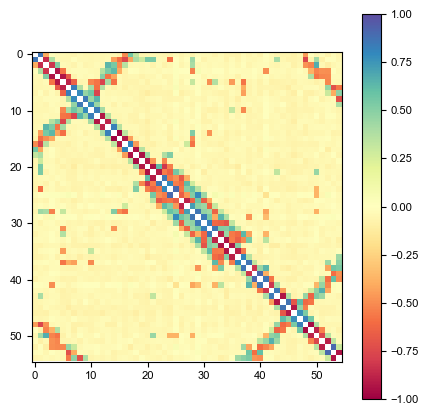

In [19]:
plt.rcParams["figure.figsize"] = (5,5)

Epavg_add = compute_avg_mat (Ep_add, n=npos)
plt.imshow (Epavg_add / np.nanmax (np.abs (Epavg_add)),
            cmap='Spectral', vmin=-1, vmax=1)
plt.colorbar ()
plt.show ()

20


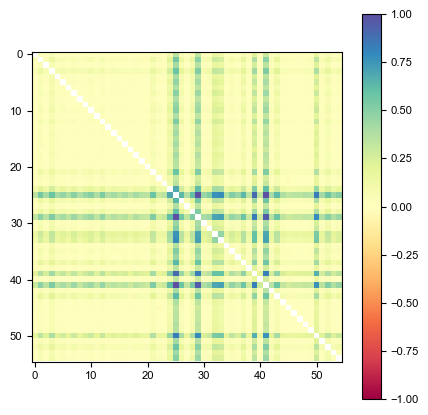

In [20]:
# find the estimated epistatic matrix 
ydoub_tmp   = (n1_doubs_therm + 1) / (n0_doubs[np.triu_indices (L, k=1)] + 1)
ydoub_therm = np.zeros_like (y_doubs)
ydoub_therm[np.triu_indices (L, k=1)] = cp.deepcopy (ydoub_tmp)
ydoub_therm += np.transpose (ydoub_therm)
ydoub_therm[np.isnan (n0_doubs)] = np.nan

y_doubs_na = cp.deepcopy (ydoub_therm)
y_doubs_na[ydoub_therm == 0] = np.nan

ysing_therm = (n1_sings_therm + 1) / (n0_sings + 1)
ysing_therm[np.isnan (n0_sings)] = np.nan
estStherm  = np.reshape (np.repeat ( np.log (ysing_therm), L), (L,L))
estStherm += np.transpose (np.reshape (np.repeat (np.log (ysing_therm), L), (L,L)) )



y_wt_therm = (n1_wt_therm + 1) / (WT_inp + 1)

Ep_therm = np.log (y_doubs_na) - estStherm + np.log (y_wt_therm)

plt.rcParams["figure.figsize"] = (5,5)

Epavg_therm = compute_avg_mat (Ep_therm, n=npos)
plt.imshow (Epavg_therm / np.nanmax (Epavg_therm), cmap='Spectral',
            vmin=-1, vmax=1)
plt.colorbar ()
plt.show ()

In [21]:
# Contact map
figsize = (1.5,1.5)

plt.rcParams["figure.figsize"] = figsize

fig, axs = plt.subplots ()

dim = axs.imshow (Dist[1:,1:], cmap='gray')

# colorbar
cbar = fig.colorbar (dim, ax=axs, shrink=0.65, location='top')
cbar.set_ticks (np.arange (0, np.nanmax (Dist), 5))
cbar.ax.set_title ('Distance, $\AA$', fontsize=8)
cbar.ax.tick_params (labelsize=7)
cbar.ax.tick_params(length=2)
cbar.ax.xaxis.set_tick_params(pad=.5)

# axes
axs.set_xticks ( np.arange (0,npos,10), np.array (np.arange (0,npos,10), dtype=int))
axs.set_yticks ( np.arange (0,npos,10), np.array (np.arange (0,npos,10), dtype=int))
axs.tick_params(length=2)
axs.xaxis.set_tick_params(pad=2)
axs.yaxis.set_tick_params(pad=1.5)
axs.set_xlabel ('Position $i$', labelpad=2)
axs.set_ylabel ('Position $j$', labelpad=2)

if save :
    plt.savefig (os.path.join (outdir, 'fig1_c.svg'), format='svg', transparent=True, dpi=600)
    plt.close ()
else :
    plt.show ()
    
# Average epistasis under additivity
plt.rcParams["figure.figsize"] = figsize
fig, axs = plt.subplots ()

maxval = np.nanmax ( np.abs (Epavg_add) )
dim = axs.imshow (Epavg_add / maxval, cmap='Spectral', vmin=-1, vmax=1)
for i in range (npos) :
    axs.add_patch( Rectangle((i-.5, i-.5), 1, 1, fill=True, color='white')) 

# title and axes
axs.set_title ('Observed epistasis', fontsize=8)
axs.set_xticks ( np.arange (0,npos,10), np.array (np.arange (0,npos,10), dtype=int))
axs.set_yticks ( np.arange (0,npos,10), np.array (np.arange (0,npos,10), dtype=int))
axs.tick_params (length=2)
axs.xaxis.set_tick_params (pad=2)
axs.yaxis.set_tick_params (pad=1.5)
axs.set_xlabel ('Position $i$', labelpad=2)
axs.set_ylabel ('Position $j$', labelpad=2)

if save :
    plt.savefig (os.path.join (outdir, 'fig1_e.svg'), format='svg', transparent=True, dpi=600)
    plt.close ()
else :
    plt.show ()

In [22]:
xs = np.linspace (np.nanmin (gamma_singles)-2, np.nanmax (gamma_singles)+2)
plt.rcParams["figure.figsize"] = figsize

fig, ax = plt.subplots ()
#fig.set_size_inches (1.75, 1.75)

# single effect histogram
ax_hist = ax.twinx() 
ax_hist.hist (-(gamma_singles+lambda_wt), color='lightgray', edgecolor='black', linewidth=.5,
              density=False, alpha=1., zorder=1, label=r'$\Lambda_i$', bins=10)
ax_hist.get_yaxis().set_visible(False)

# change plotting order
ax.set_zorder(ax_hist.get_zorder()+1)
ax.patch.set_visible(False)

# plot nonlinearity
ax.plot (-(xs + lambda_wt), 1 / (1. + np.exp (xs + lambda_wt)),
         color='black', linewidth=1., label=r'$g_{true}$')

ythres = 1 / (1. + np.exp (xs + lambda_wt))
ythres[ythres < .05] = 0.05
ax.plot (-(xs + lambda_wt), ythres, color='orange',
         linewidth=1, linestyle='dashed', label=r'$g_{app}$')

# plot wildtype
ax.scatter (-lambda_wt, 1 / (1. + np.exp (lambda_wt)),
            color='white', edgecolor='black', linewidth=.5, label='$wt$', s=25, zorder=3)

ax.set_xlabel ('$\Lambda (\mathbf{x})$', labelpad=2)
ax.set_ylabel ('$Y (\mathbf{x})$', labelpad=2)

ax.legend (frameon=False, handlelength=1., loc='upper left')
ax.locator_params(axis='x', nbins=5)
ax.tick_params (length=2)
ax.xaxis.set_tick_params (pad=2)
ax.yaxis.set_tick_params (pad=1.5)
ax.set_title ('Global nonlinearity', fontsize=8)

if save :
    plt.savefig (os.path.join (outdir, 'fig1_d.svg'), transparent=True, dpi=600)
    plt.close ()
else :
    plt.show ()

In [23]:
bigS  = np.reshape (np.repeat ( gamma_singles, L), (L,L))
bigS += np.transpose (np.reshape (np.repeat (gamma_singles, L), (L,L)) )
bigS += bigImat

p_doubles = 1 / (1. + np.exp (bigS + lambda_wt)) + ns
#p_doubles[np.isnan (p_doubles)] = 0.

estS  = np.reshape (np.repeat ( np.log (y_sings), L), (L,L))
estS += np.transpose (np.reshape (np.repeat (np.log (y_sings), L), (L,L)) )

y_doubs = np.loadtxt ( os.path.join (indir, protein + '_Y_doubles.txt'))

y_doubs_na = cp.deepcopy (y_doubs)
y_doubs_na[y_doubs == 0] = np.nan

Ep = np.log (y_doubs_na) - estS + np.log (y_wt)

In [24]:
avgEp = compute_avg_mat (Ep, npos)
avgI  = compute_avg_mat (bigImat, npos)

20
20


In [25]:
mean_y     = np.zeros (npos)
mean_y_obs = np.zeros (npos)
for i in range (npos) :
    mean_y[i] = np.nanmean (y_sings[i*nAA:(i*nAA + nAA)])
    mean_y_obs[i] = np.nanmean (y_sings_obs[i*nAA:(i*nAA + nAA)])

In [26]:
bigS_obs  = np.reshape (np.repeat ( np.log (y_sings_obs), L), (L,L))
bigS_obs += np.transpose (np.reshape (np.repeat ( np.log (y_sings_obs), L), (L,L)) )

Ep_obs = np.log (y_doubs_obs) - bigS_obs + np.log (y_wt_obs)
Ep_obs_avg = compute_avg_mat ( Ep_obs, npos)

20


In [27]:
mean_y = np.zeros (npos)
for i in range (npos) :
    mean_y[i] = np.nanmean (y_sings[i*nAA:(i*nAA + nAA)])

In [28]:
plt.rcParams["figure.figsize"] = figsize

fig, axs = plt.subplots ()

#maxval = np.nanmax (np.abs (avgEp))
#fig1 = axs.imshow (avgEp / maxval, cmap='Spectral', vmin=-1, vmax=1)
maxval = np.nanmax (np.abs (Epavg_therm))
fig1 = axs.imshow (Epavg_therm / maxval, cmap='Spectral', vmin=-1, vmax=1)
axs.set_xlabel ('Position $i$', labelpad=2)
axs.set_ylabel ('Position $j$', labelpad=2)

axs.set_title ('Observed epistasis', fontsize=8)

axs.set_xticks ( np.arange (0,npos,10), np.array (np.arange (0,npos,10), dtype=int))
axs.set_yticks ( np.arange (0,npos,10), np.array (np.arange (0,npos,10), dtype=int))
axs.tick_params (length=2)
axs.xaxis.set_tick_params (pad=2)
axs.yaxis.set_tick_params (pad=1.5)

if save :
    plt.savefig (os.path.join (outdir, 'fig1_f.svg'),
                 bbox_inches='tight', format='svg', transparent=True, dpi=600)
    plt.close ()
else :
    plt.show ()

In [29]:
Mmat = np.zeros ( (7, 5))
for i in range (3) :
    Mmat[i+1,i] = 1
Mmat[4:,0] = 1
for j in range (3) :
    Mmat[4+j,j+1] = 1

In [30]:
positions = [10, 8.5, 7.5, 6.5, 4.5, 3.5, 2.5]

In [31]:
cmap = mpl.colors.LinearSegmentedColormap.from_list ('cow', colors=['white', 'black'])

In [32]:
plt.rcParams["figure.figsize"] = (1,2)

fig, axs = plt.subplots ()

for i in range (7) :
    axs.scatter (np.arange (5), np.repeat (positions[i],5),
                 s=40,
                 c=Mmat[i,:], cmap=cmap, edgecolor='black', linewidth=.5)
    
axs.set_xlim ((-.5,5.5))
axs.spines['bottom'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.spines['top'].set_visible(False)

#axs.get_xaxis().set_visible(False)
axs.get_yaxis().set_visible(False)
axs.set_ylim ((0,11))
axs.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
axs.set_xticks ( np.arange (0,5,1), np.arange (0,5,1))
axs.tick_params (length=0)
axs.xaxis.set_tick_params (pad=-3)

if save :
    plt.savefig (os.path.join (outdir, 'fig1_b.svg'),
                 bbox_inches='tight', format='svg', transparent=True, dpi=600)
    plt.close ()
else :
    plt.show ()

In [33]:
plt.rcParams["figure.figsize"] = (1.75,1.75)

fig, axs = plt.subplots ()

#maxval = np.nanmax (np.abs (Ep_obs_avg))
#fig1 = axs.imshow (Ep_obs_avg / maxval, cmap='Spectral', vmin=-1, vmax=1)
maxval = np.nanmax (np.abs (avgEp))
fig1 = axs.imshow (avgEp / maxval, cmap='Spectral', vmin=-1, vmax=1)
axs.set_xlabel ('Position $i$')
axs.set_ylabel ('Position $j$')
axs.set_xticks (np.arange (0, npos, 10), np.array (np.arange (0,npos,10), dtype=int))
axs.set_yticks (np.arange (0, npos, 10), np.array (np.arange (0,npos,10), dtype=int))
axs.tick_params (length=2)
axs.xaxis.set_tick_params (pad=2)
axs.yaxis.set_tick_params (pad=1.5)
axs.set_title ('Observed epistasis')

if save :
    plt.savefig (os.path.join (outdir, 'fig1_g.svg'),
                 bbox_inches='tight', format='svg', transparent=True, dpi=600)
    plt.close ()
else :
    plt.show ()

In [34]:
plt.rcParams["figure.figsize"] = (1.75,1.75)

fig, axs = plt.subplots ()

maxval = np.nanmax (np.abs (Ep_obs_avg))
fig1 = axs.imshow (Ep_obs_avg / maxval, cmap='Spectral', vmin=-1, vmax=1)
axs.set_xlabel ('Position $i$')
axs.set_ylabel ('Position $j$')
axs.set_xticks (np.arange (0, npos, 10), np.array (np.arange (0,npos,10), dtype=int))
axs.set_yticks (np.arange (0, npos, 10), np.array (np.arange (0,npos,10), dtype=int))
axs.tick_params (length=2)
axs.xaxis.set_tick_params (pad=2)
axs.yaxis.set_tick_params (pad=1.5)

cbar = fig.colorbar (fig1, ax=axs, orientation='horizontal',
                     location='top', label=r'$\bar e_{ij}$',
                     shrink=0.75)
cbar.set_ticks (np.linspace (-1, 1, 5))
cbar.ax.tick_params (labelsize=7)
cbar.ax.tick_params(length=2)
cbar.ax.xaxis.set_tick_params(pad=.5)

if save :
    plt.savefig (os.path.join (outdir, 'fig1_colorbar.svg'),
                 bbox_inches='tight', format='svg', transparent=True, dpi=600)
    plt.close ()
else :
    plt.show ()

In [35]:
plt.rcParams["figure.figsize"] = (8,4)

fig, axs = plt.subplots (1, 2, constrained_layout=True)

maxval = np.nanmax (np.abs (avgEp))
fig1 = axs[0].imshow (avgEp / maxval, cmap='BrBG', vmin=-1, vmax=1)
axs[0].set_xlabel ('Position $i$')
axs[0].set_ylabel ('Position $j$')

fig2 = axs[1].imshow ( (avgEp / maxval)[np.argsort (mean_y), :][:, np.argsort (mean_y)], cmap='BrBG', vmin=-1, vmax=1)
axs[1].set_xlabel ('$\hat R_i$')
axs[1].set_ylabel ('$\hat R_j$')

fig.colorbar (fig2, ax=axs[1], label=r'$\bar e_{ij}$', shrink=.7)

if save :
    plt.savefig (os.path.join (outdir, 'mult_ep_mat.pdf'), bbox_inches='tight')
    plt.close ()
else :
    plt.show ()

In [36]:
plt.rcParams["figure.figsize"] = (8,4)

fig, axs = plt.subplots (1, 2, constrained_layout=True)

maxval = np.nanmax (np.abs (Ep_obs_avg))
fig1 = axs[0].imshow (Ep_obs_avg / maxval, cmap='BrBG', vmin=-1, vmax=1)
axs[0].set_xlabel ('Position $i$')
axs[0].set_ylabel ('Position $j$')
axs[0].set_xticks (np.arange (0, npos, 10), np.array (np.arange (0,npos,10), dtype=int))
axs[0].set_yticks (np.arange (0, npos, 10), np.array (np.arange (0,npos,10), dtype=int))

fig2 = axs[1].imshow ( (Ep_obs_avg / maxval)[np.argsort (mean_y_obs), :][:, np.argsort (mean_y_obs)],
                      cmap='BrBG', vmin=-1, vmax=1)
axs[1].set_xlabel ('$\hat R_i$')
axs[1].set_ylabel ('$\hat R_j$')
axs[1].set_xticks (np.arange (0, npos, 10), np.array (np.arange (0,npos,10), dtype=int))
axs[1].set_yticks (np.arange (0, npos, 10), np.array (np.arange (0,npos,10), dtype=int))

fig.colorbar (fig2, ax=axs[1], label=r'$\bar e_{ij}$', shrink=.7)

if save :
    plt.savefig (os.path.join (outdir, 'mult_ep_mat_obs.pdf'), bbox_inches='tight')
    plt.close ()
else :
    plt.show ()

In [37]:
# spearmans correlation matrix
Rho    = compute_rho_mat (Rm, thres=10)
avgRho = compute_avg_mat (Rho, npos)

20


In [38]:
#plt.rcParams["figure.figsize"] = (5, 5)
for make_cbar in [True, False] :
    
    if make_cbar :
        plt.rcParams["figure.figsize"] = (1.4, 1.4)
    else :
        plt.rcParams["figure.figsize"] = (1.2, 1.2)

    
    fig, axs = plt.subplots ()

    Rho_gb_sorted = cp.deepcopy (Rho[np.argsort (y_sings),:][:,np.argsort (y_sings)][:-npos,:][:,:-npos])
    hm = axs.imshow (Rho_gb_sorted, cmap='Blues_r',
                     #vmin=np.nanmin ([np.nanmin (Rho), np.round (np.nanmin (Rho),1)]),
                     vmax=1, interpolation='None')
    axs.tick_params (labelsize=6, length=2, pad=2)

    axs.set_ylabel (r'$\hat R_{j}$', labelpad=0)
    axs.set_xlabel (r'$\hat R_{i}$', labelpad=2)
    axs.set_xticks (np.arange (0, L, 500), labels=np.arange (0,L,500))
    axs.set_yticks (np.arange (0, L, 500), labels=np.arange (0,L,500))

    for i in range (L) :
        axs.add_patch( Rectangle((i-.5, i-.5), 1, 1, fill=True, color='gray')) 


    if make_cbar :
        cbar = fig.colorbar (hm, ax=axs, orientation='horizontal',
                             location='top', label=r'$\hat \rho_{ij}$',
                             shrink=0.6, aspect=15)
        cbar.set_ticks (np.linspace (0, 1, 3))
        cbar.ax.tick_params (labelsize=6)
        cbar.ax.tick_params(length=2)
        cbar.ax.xaxis.set_tick_params(pad=.5)

    if save :
        plt.savefig (os.path.join (outdir, 'fig2_b_' + str (make_cbar) + '.svg'),
                     bbox_inches='tight', format='svg', transparent=True, dpi=600)
        plt.close ()
    else :
        plt.show ()

In [39]:
# PLOT GP MAPS
plt.rcParams["figure.figsize"] = (2,2)
#plt.rcParams["figure.figsize"] = (4, 2)

fig, axs = plt.subplots (2, 1, height_ratios=[1,2], sharex='col', sharey='row', constrained_layout=True)

ct = 0

ysings = cp.deepcopy (y_sings)
Ymat   = np.reshape (np.repeat (y_sings, L), (L,L))
Yij    = Ymat + np.transpose (Ymat)
Yd     = cp.deepcopy (y_doubs)

lambda_singles = np.loadtxt (os.path.join (indir, 'sampled_single_lambdas.txt'))

# compute lambda matrix
Lambda_mat = np.reshape (np.repeat (lambda_singles, L), (L,L))
Lij        = Lambda_mat + np.transpose (Lambda_mat) + bigImat + 1.34

myh = axs[0].hist (-(lambda_singles+1.34), label=r'singles',
                color='gray', edgecolor='black', linewidth=.05)

myp = axs[1].hexbin (-Lij[np.triu_indices (L, k=1)], y=Yd[np.triu_indices (L, k=1)],
                        yscale='log', cmap='Blues',
                       norm=mpl.colors.LogNorm (), gridsize=15, edgecolor='black',
                        linewidth=0, label='doubles')
if ct == 1 :
    leg = axs[0].legend (frameon=False, handlelength=0, handletextpad=0, loc='upper left', fontsize=6)
    for item in leg.legend_handles:
        item.set_visible(False)
    axs[1].legend (frameon=False, handlelength=0, loc='upper left', fontsize=6)

axs[1].axvline (-1.34, linestyle='--', linewidth=.5, color='black')
axs[0].axvline (-1.34, linestyle='--', linewidth=.5, color='black')

axs[1].set_xlabel (r'$\Lambda$', labelpad=2, fontsize=8)
axs[1].set_yscale ('log')
axs[1].tick_params (length=2, labelsize=6, pad=1)
axs[0].tick_params (length=2, labelsize=6, pad=1)

minval = -np.round (np.nanmax (Lij) / 10) * 10
maxval = -(np.round (np.nanmin (Lij) / 10) * 10)

if ct == 0 :
    interval = 5
else :
    interval = 10

axs[1].set_xticks ( np.arange (minval,maxval+1,interval),
                       np.array (np.arange (minval,maxval+1,interval), dtype=int))
ct += 1
    
cbar = fig.colorbar (myp, ax=axs[-1],  shrink=0.75, aspect=10)

axs[1].set_ylabel (r'$\hat Y$', labelpad=-2, fontsize=8)
axs[0].set_ylabel ('Count', labelpad=1, fontsize=6)

if save :
    plt.savefig (os.path.join (outdir, 'fig3_a.svg'),
                 format='svg', transparent=True, dpi=600, bbox_inches='tight')
    plt.close ()
else :
    plt.show ()

In [40]:
plt.rcParams["figure.figsize"] = (5, 2)

fig, axs = plt.subplots (1,2,sharex=True, constrained_layout=True)

maxval = np.sum (~np.isnan (y_sings))

axs[0].scatter (compute_mean_ranks (y_sings), compute_mean_ranks (np.nanmean (Rmat, axis=0)),
             color='lightgray', alpha=0.9, edgecolor='black', linewidth=.01)
axs[0].set_xticks (np.arange (0, L, 500), labels=np.arange (0,L,500))
axs[0].set_ylabel (r'$R (\bar {R}_{\cdot, i})$', fontsize=16)
axs[0].set_xlabel (r'$\hat R_{i}$', fontsize=16)
axs[0].plot (np.linspace (0, maxval, 100), np.linspace (0, maxval, 100),
          color='black', linestyle='dashed', linewidth=.5, label='ident.')
axs[0].legend (frameon=False, loc='lower right', fontsize=10)


axs[1].scatter (compute_mean_ranks (y_sings), np.nanmax (Rho, axis=1),
             color='lightgray', alpha=0.9, edgecolor='black', linewidth=.01)
axs[1].set_xticks (np.arange (0, L, 500), labels=np.arange (0,L,500))
axs[1].set_ylabel (r'$\hat{\rho}^{max}_{i}$', fontsize=16)
axs[1].set_xlabel (r'$\hat R_{i}$', fontsize=16)
axs[1].axhline (y=1, color='black', linestyle='dashed', linewidth=.5,
                label=r'$\hat{\rho}^{max} = 1$')
axs[1].legend (frameon=False, loc='lower right', fontsize=10)
axs[1].set_ylim ((0,1.05))

if save :
    plt.savefig (os.path.join (outdir, 'sims_average_rank.pdf'), bbox_inches='tight')
    plt.close ()
else :
    plt.show ()

/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_8476/1911178109.py:7: RuntimeWarning: Mean of empty slice
  axs[0].scatter (compute_mean_ranks (y_sings), compute_mean_ranks (np.nanmean (Rmat, axis=0)),
/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_8476/1911178109.py:17: RuntimeWarning: All-NaN slice encountered
  axs[1].scatter (compute_mean_ranks (y_sings), np.nanmax (Rho, axis=1),


In [41]:
# pick focal positions
nqs = 3
#myqs = np.linspace (.1,.99,nqs)
myqs = [.05,.2,.99]
qs = np.quantile ( y_sings[~np.isnan (y_sings)], myqs)

foci     = [np.nanargmin ( np.abs (y_sings - q) ) for q in qs]
var_foci = list ()
for i in range (nqs) :
    vals = cp.deepcopy (y_doubs[foci[i],:])
    var_foci.append ( cp.deepcopy (vals[~np.isnan (vals)])  )

In [42]:
plt.rcParams["figure.figsize"] = (6,3)

foc_colors = [myspectral[x] for x in [0,2,7,9]]
foc_colors = ['peru', 'firebrick', 'dimgray']

fig, axs = plt.subplots (1, 2, sharex='row', constrained_layout=True)

bplot = axs[1].violinplot (var_foci, vert=False, showmedians=True)
axs[1].set_xscale ('log')
axs[1].set_ylabel ('Quantile $i$', fontsize=16)
axs[1].set_yticks(range (1,nqs+1), np.round (myqs, 2))

# fill with colors
for pc, color in zip(bplot['bodies'], foc_colors):
    pc.set_facecolor(color)

for element in ['cbars','cmedians','cmaxes','cmins'] :   
    bplot[element].set_color(foc_colors)
    bplot[element].set_linewidth (.5)

bins  = np.logspace (np.log10 (np.nanmin (y_sings)), np.log10 (np.nanmax (y_sings)), 15)
yhist = axs[0].hist (y_sings, bins=bins, color='lightgray', edgecolor='black', linewidth=0.5)

for i in range (nqs) :
    axs[0].axvline ( y_sings[foci[i]], linestyle='--', linewidth=1.5, color=foc_colors[i] )

axs[0].set_ylabel ('Count', fontsize=16)
axs[0].set_xlabel (r'$\hat Y_{i}$', fontsize=16)
axs[1].set_xlabel (r'$\hat Y_{ij}$', fontsize=16)
axs[1].set_xscale ('log')

if save :
    plt.savefig (os.path.join (outdir, 'GE_A.pdf'), bbox_inches='tight')
    plt.close ()
else :
    plt.show ()

In [43]:
plt.rcParams["figure.figsize"] = (1.2,1.2)
foc_colors = ['peru', 'firebrick', 'dimgray']

fig, ax = plt.subplots ()

bins = np.linspace (np.nanmin (-xs), np.nanmax (-xs), 20)
#ax2 = ax.twinx ()
ct = 0
for i in foci :
    ax.hist (-Lij[i,:], color=foc_colors[ct], bins=bins, density=True,
              alpha=.5, edgecolor='black', linewidth=.1, zorder=1)

    ct += 1

#ax.set_zorder (ax2.get_zorder() + 1)
ax.patch.set_visible (False)
ax.plot (-(xs), 1 / (1+np.exp (xs)), color='black')

ct = 0
for i in foci :
    ax.axvline (-lambda_singles[i], color=foc_colors[ct], linestyle='dashed', linewidth=.75,
                label=myqs[ct])
    ct += 1

ax.set_xlabel ('$\Lambda (\mathbf{x})$', labelpad=2)
ax.set_ylabel ('$Y (\mathbf{x})$', labelpad=2)
#ax2.set_ylabel ('Count', labelpad=8, rotation=270)

#leg = ax.legend (frameon=False, handlelength=1., loc='upper left',
#                 fontsize=6, title='Quantile')
leg = ax.legend (frameon=False, handlelength=1., loc='upper center', ncol=3, 
                 fontsize=6, title='Quantile', bbox_to_anchor=(.5,1.35), columnspacing=.5)
leg.get_title().set_fontsize('7')
ax.locator_params(axis='x', nbins=5)

for axis in [ax] :
    axis.tick_params (length=2, labelsize=6)
    axis.xaxis.set_tick_params (pad=2)
    axis.yaxis.set_tick_params (pad=1.5)

if save :
    plt.savefig (os.path.join (outdir, 'fig2_a.svg'),
                 bbox_inches='tight', format='svg', transparent=True, dpi=600)
    plt.close ()
else :
    plt.show ()

In [44]:
plt.rcParams["figure.figsize"] = (1.2, .2)


for i in range (len (foci)) :

    fig, axs = plt.subplots ()
    if i == 0 :
        foc_colors = ['peru', 'firebrick', 'dimgray']
    elif i == 1 :
        foc_colors = ['firebrick', 'peru']
    else :
        foc_colors = ['dimgray', 'peru']
    
    bplot = axs.violinplot (var_foci[i], vert=False, showmedians=True)
   
    axs.xaxis.set_label_position('top')
    axs.set_xscale ('log')
    axs.set_xlim ((np.nanmin (y_doubs), np.nanmax (y_doubs)+1))
    axs.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    axs.tick_params (axis='x', which='minor', top=True, bottom=False)

    axs.tick_params (length=2)
    axs.xaxis.set_tick_params (pad=0, labelsize=6, top=True)
    axs.get_yaxis().set_ticks([])
    axs.set_xlabel (r'$\hat Y_{ij}$', labelpad=0, fontsize=6)

 

    # fill with colors
    for pc, color in zip(bplot['bodies'], foc_colors):
        pc.set_facecolor (color)

    for element in ['cbars','cmedians','cmaxes','cmins'] :   
        bplot[element].set_color (foc_colors[0])
        bplot[element].set_linewidth (.5)

    if save :
        plt.savefig (os.path.join (outdir, 'fig2_c_top_' + str (i) + '.svg'),
                     bbox_inches='tight', format='svg', transparent=True, dpi=600)
        plt.close ()
    else :
        plt.show ()

In [45]:
plt.rcParams["figure.figsize"] = (1.2*3.4,1.2)

# PART 2
nImat  = np.abs (bigImat)
nImat /= np.nanmax (nImat)**.25
nImat[np.isnan (nImat)] = 0

bigI = np.abs (bigImat)
bigI[np.isnan (bigImat)] = 0

ivals = cp.deepcopy (np.abs (bigImat))
print (np.quantile (vals[~np.isnan (vals)], .9))

fig, axs = plt.subplots (1, 3, sharex=True, sharey=True, constrained_layout=False)

for i in range (nqs) :

    print (np.nanmax (np.abs (bigImat[foci[i],:])))
    
    M_i = np.nanmax (rank_ys)
    myp = axs[i].scatter (rank_ys, transform_ranks (Rmat[foci[i],:], M_i),
                            cmap='Spectral',
                            c=bigImat[foci[i],:] / np.quantile (ivals[~np.isnan (ivals)], .99),
                            vmin=-1, vmax=1, s=5,
                          #cmap='gray_r', c=(bigI[foci[i],:])**.8 / (np.nanmax (bigI))**.8, 
                    #vmin=0, vmax=1, s=10,
                    linewidth=.1, edgecolor='black')
    axs[i].set_xticks ( np.linspace (0, 1000, 3), [int (x) for x in np.linspace (0, 1000, 3)])
    axs[i].set_yticks  (np.linspace (0, 1000, 3), [int (x) for x in np.linspace (0, 1000, 3)])
    axs[i].set_xlabel (r'$\hat R_{i}$', labelpad=2)
    if i == 0 :
        axs[i].set_ylabel (r'$\hat R_{ji}$', labelpad=0)

    # add vertical line
    top_i = np.argmax (bigI[foci[i],:])
    
    # identity line
    axs[i].plot ( np.linspace (0, M_i, 10), 
                                   np.linspace (0, np.nanmax (rank_ys), 10),
                                   linewidth=.5, linestyle='dashed', color='black')   
    
    ymin_j = np.nanmin ([Rmat[foci[i],top_i], rank_ys[top_i]])
    ymax_j = np.nanmax ([Rmat[foci[i],top_i], rank_ys[top_i]])
    vals   = np.linspace (ymin_j, ymax_j, 20)   
    
    axs[i].tick_params (length=2, labelsize=6)
    axs[i].xaxis.set_tick_params (pad=2)
    axs[i].yaxis.set_tick_params (pad=1.5)

if save :
    plt.savefig (os.path.join (outdir, 'fig2_c_bottom.svg'),
                 bbox_inches='tight', format='svg', transparent=True, dpi=600)
    plt.close ()
else :
    plt.show ()

2.75
2.033325302755733
2.9905755984555595
2.451601192397672


In [46]:
plt.rcParams["figure.figsize"] = (1.*3.4,1.)

ivals = cp.deepcopy (np.abs (bigImat))
fig, axs = plt.subplots (1, 3, sharex=True, sharey=True, constrained_layout=False)
for i in range (nqs) :
    M_i = np.nanmax (rank_ys)
    myp = axs[i].scatter (rank_ys, transform_ranks (Rmat[foci[i],:], M_i),
                            cmap='Spectral',
                            c=bigImat[foci[i],:] / np.quantile (ivals[~np.isnan (ivals)], .99),
                            vmin=-1, vmax=1, s=5,
                    linewidth=.1, edgecolor='black')

    if i == 2 :
        cbar = fig.colorbar (myp, ax=axs[i], location='right', shrink=0.75, 
                             label='normalized $\lambda_{ij}$')
        cbar.ax.tick_params (labelsize=7)
        cbar.ax.tick_params(length=2)
        cbar.ax.xaxis.set_tick_params(pad=.5)


if save :
    plt.savefig (os.path.join (outdir, 'fig2_c_colorbar.svg'),
                 bbox_inches='tight', format='svg', transparent=True, dpi=600)
    plt.close ()
else :
    plt.show ()

In [47]:
# sample one round
n0_cp = cp.deepcopy (n0_sings)
n0_cp[np.isnan (n0_cp)] = 0
n1_cp = cp.deepcopy (n1_sings)
n1_cp[np.isnan (n1_cp)] = 0

In [48]:
# maximum value
maxD = 1000

In [49]:
aadict = make_aa_dict ()
aas    = [key for key in aadict.keys ()]
all_labels = list ()
for i in range (npos) :
    for a in aas :
        all_labels.append (wt_seq[i] + str (i) + a)

In [50]:
# choose top interactions from a set of consecutive positions
pos_min, pos_max = 0, 10
pos_min, pos_max = 20, 30

# pick random mutations from within range
idxs = list ()
for i in range (pos_min, pos_max) :
    sample_i = np.arange (0, nAA, 1)[~np.isnan (rank_ys[i*nAA:(i*nAA + nAA)])]
    idxs.append ( i*nAA + myrng.choice (sample_i, 1)[0])

idxs = np.array (idxs, dtype=int)
xs   = np.array ([rank_ys[i] for i in idxs], dtype=int)

sub_labels = [all_labels[i] for i in idxs]
nvals = len (xs)

In [51]:
print (xs)
print (idxs)

[ 931  203 1026  925  129   54  185  785  481   16]
[409 430 455 479 481 502 536 559 564 585]


In [52]:
plt.rcParams["figure.figsize"] = (1.4,1.4)

fig, axs = plt.subplots ()

labels = [1,2,3]
#xcomb, ycomb = [3,5,7], [0,4,8]
xcomb, ycomb = [0,0,7], [1,8,8]

x_ranks = compute_mean_ranks (xs)
new_pos = np.arange (pos_min+1, pos_max+1, 1)
impos   = axs.imshow (Dmat[np.sort (idxs),:][:,np.sort (idxs)],
                    cmap='Spectral', vmin=-maxD, vmax=maxD)

of = .1
# add rectangles around focal position pairs
for i in range (len (xcomb)) :
    x_i = xcomb[i]
    y_i = ycomb[i]
    
    axs.add_patch( Rectangle((x_i-.5, y_i-.5), 1, 1, fill=False, edgecolor='black',  lw=1))  
    axs.add_patch( Rectangle((y_i-.5, x_i-.5), 1, 1, fill=False, edgecolor='black',  lw=1))
    axs.annotate( labels[i], (x_i-3*of, y_i+3.5*of), color='black', weight='bold')
    axs.annotate( labels[i], (y_i-3*of, x_i+3.5*of), color='black', weight='bold')

axs.xaxis.tick_top()
axs.set_yticks ( np.arange (0, nvals, 1), sub_labels)
axs.set_xticks ( np.arange (0, nvals, 1), sub_labels, rotation=60 )
axs.tick_params (length=2)
axs.xaxis.set_tick_params (pad=1.5)
axs.yaxis.set_tick_params (pad=1.5)
axs.tick_params (axis='both', labelsize=6)
axs.tick_params (labelbottom=False, labeltop=True)

axs.set_ylabel (r'Mutation $j$', labelpad=0)
axs.set_xlabel (r'Mutation $i$', labelpad=0)
axs.xaxis.set_label_position('top')

if save :
    plt.savefig (os.path.join (outdir, 'fig2_d_top.svg'),
                 bbox_inches='tight', format='svg', transparent=True, dpi=600)
    plt.close ()
else :
    plt.show ()


In [53]:
plt.rcParams["figure.figsize"] = (1.4,1.4)

fig, axs = plt.subplots ()

axs.imshow (Dmat[idxs[np.argsort (xs)],:][:,idxs[np.argsort (xs)]],
               cmap='Spectral', vmin=-maxD, vmax=maxD)
axs.set_xticks ( np.arange (0, nvals, 1), np.sort (xs), rotation=60 )
axs.set_yticks ( np.arange (0, nvals, 1), np.sort (xs))
axs.set_xlabel (r'$\hat R_i$', labelpad=0)
axs.set_ylabel (r'$\hat R_j$', labelpad=0)
axs.tick_params (length=2)
axs.xaxis.set_tick_params (pad=1.5)
axs.yaxis.set_tick_params (pad=1.5)
axs.tick_params (axis='both', labelsize=6)

for i in range (len (xcomb)) :
    x_i = x_ranks[xcomb[i]]
    y_i = x_ranks[ycomb[i]]
    axs.add_patch( Rectangle((x_i-.5, y_i-.5), 1, 1, fill=False, edgecolor='black',  lw=1))  
    axs.add_patch( Rectangle((y_i-.5, x_i-.5), 1, 1, fill=False, edgecolor='black',  lw=1))
    axs.annotate( labels[i], (x_i-3*of, y_i+3.5*of), color='black', weight='bold')
    axs.annotate( labels[i], (y_i-3*of, x_i+3.5*of), color='black', weight='bold')
      
if save :
    plt.savefig (os.path.join (outdir, 'fig2_d_bottom.svg'),
                 bbox_inches='tight', format='svg', transparent=True, dpi=600)
    plt.close ()
else :
    plt.show ()

In [54]:
plt.rcParams["figure.figsize"] = (1.4,1.4)

fig, axs = plt.subplots ()

ymin = np.nanmin (y_sings)
ymax = np.nanmax (y_sings)

myp = axs.imshow (np.reshape (y_sings[idxs], (1,len(idxs))),
                     norm=mpl.colors.LogNorm (vmin=ymin, vmax=ymax), cmap='gray')
axs.set_xticks (np.arange (0, len (idxs), 1), ['']*len (idxs))
axs.get_yaxis().set_visible (False)
axs.get_xaxis().set_visible (False)

axs.xaxis.tick_top()
axs.tick_params (length=2)
axs.xaxis.set_tick_params (pad=1.5)
axs.yaxis.set_tick_params (pad=1.5)
axs.tick_params (axis='both', labelsize=6, rotation=60)

if save :
    plt.savefig (os.path.join (outdir, 'fig2_d_top_y.svg'),
                 bbox_inches='tight', format='svg', transparent=True, dpi=600)
    plt.close ()
else :
    plt.show ()

In [55]:
plt.rcParams["figure.figsize"] = (1.4,1.4)

fig, axs = plt.subplots ()

myp = axs.imshow (np.reshape (np.sort (y_sings[idxs]), (1, len(idxs))),
                  norm=mpl.colors.LogNorm (vmin=ymin, vmax=ymax), cmap='gray')
#fig.colorbar (myp, ax=axs[1], shrink=0.5, label=r'$\hat Y_j$', pad=.05 )

axs.set_xticks (np.arange (0, len (idxs), 1), ['']*len (idxs))
axs.get_yaxis().set_visible (False)
axs.get_xaxis().set_visible (False)

#axs.xaxis.tick_top()
axs.tick_params (length=2)
axs.xaxis.set_tick_params (pad=1.5)
axs.yaxis.set_tick_params (pad=1.5)
axs.tick_params (axis='both', labelsize=6, rotation=60)
if save :
    plt.savefig (os.path.join (outdir, 'fig2_d_bottom_y.svg'),
                 bbox_inches='tight', format='svg', transparent=True, dpi=600)
    plt.close ()
else :
    plt.show ()

In [56]:
j = 0 # simulation index

if large_file :
    Dsim_j  = cp.deepcopy (Dsim_unsorted[j,:,:])
    Dsim_j += np.transpose (Dsim_j)

    Dsim_sort_j = cp.deepcopy (Dsim[j,:,:])
    Dsim_sort_j += np.transpose (Dsim_sort_j)
    
    np.savetxt (os.path.join (indir, 'Dsim_j.txt'), Dsim_j)
    np.savetxt (os.path.join (indir, 'Dsim_sort_j.txt'), Dsim_sort_j)
    
else :
    Dsim_j      = np.loadtxt (os.path.join (indir, 'Dsim_j.txt'))
    Dsim_sort_j = np.loadtxt (os.path.join (indir, 'Dsim_sort_j.txt'))

# compute unique ranks for the single mutations
sim_ranks = compute_rank_sample (ybs[:,j], rng=myrng)
yjs       = cp.deepcopy (ybs[:,j])

# get the indices of mutations that have the right ranks
j_idxs    = [i for i in range (L) if sim_ranks[i] in xs]
print (j_idxs)
j_labels = [all_labels[i] for i in j_idxs]
print (j_labels)

[287, 361, 570, 641, 653, 785, 800, 874, 924, 985]
['T14G', 'A18R', 'F28K', 'A32R', 'A32P', 'G39E', 'E40A', 'Y43S', 'A46C', 'T49E']


In [57]:
plt.rcParams["figure.figsize"] = (1.4,1.4)

fig, axs = plt.subplots ()

x_ranks = compute_mean_ranks (xs)

new_pos = np.arange (pos_min+1, pos_max+1, 1)

Cnon = np.zeros ((len (j_idxs), len (j_idxs))) * np.nan
axs.imshow (Cnon)

impos = axs.imshow (Dsim_j[np.sort (j_idxs),:][:,np.sort (j_idxs)],
                    cmap='Spectral', vmin=-maxD, vmax=maxD)

axs.xaxis.tick_top()
axs.set_yticks ( np.arange (0, nvals, 1), j_labels)
axs.set_xticks ( np.arange (0, nvals, 1), j_labels, rotation=60 )
axs.tick_params (length=2)
axs.xaxis.set_tick_params (pad=1.5)
axs.yaxis.set_tick_params (pad=1.5)
axs.tick_params (axis='both', labelsize=6)
axs.tick_params (labelbottom=False, labeltop=True)

axs.set_ylabel (r'Mutation $j$', labelpad=0)
axs.set_xlabel (r'Mutation $i$', labelpad=0)
axs.xaxis.set_label_position('top')

if save :
    plt.savefig (os.path.join (outdir, 'fig2_e_top.svg'),
                 bbox_inches='tight', format='svg', transparent=True, dpi=600)
    plt.close ()
else :
    plt.show ()

In [58]:
plt.rcParams["figure.figsize"] = (1.4,1.4)
fig, axs = plt.subplots ()

Cnon = np.zeros ((len (j_idxs), len (j_idxs))) * np.nan
axs.imshow (Cnon)

np.fill_diagonal (Dsim_sort_j, np.nan)
axs.imshow (Dsim_sort_j[np.sort (xs),:][:,np.sort (xs)],
            cmap='Spectral', vmin=-maxD, vmax=maxD)
axs.set_xticks ( np.arange (0, nvals, 1), np.sort (xs), rotation=60 )
axs.set_yticks ( np.arange (0, nvals, 1), np.sort (xs))
axs.set_xlabel (r'$\hat R_i^b$', labelpad=0)
axs.set_ylabel (r'$\hat R_j^b$', labelpad=0)
axs.tick_params (length=2)
axs.xaxis.set_tick_params (pad=1.5)
axs.yaxis.set_tick_params (pad=1.5)
axs.tick_params (axis='both', labelsize=6)

for i in range (len (xcomb)) :
    x_i = x_ranks[xcomb[i]]
    y_i = x_ranks[ycomb[i]]
    axs.add_patch( Rectangle((x_i-.5, y_i-.5), 1, 1, fill=False, edgecolor='black',  lw=1))  
    axs.add_patch( Rectangle((y_i-.5, x_i-.5), 1, 1, fill=False, edgecolor='black',  lw=1))
    axs.annotate( labels[i], (x_i-3*of, y_i+3.5*of), color='black', weight='bold')
    axs.annotate( labels[i], (y_i-3*of, x_i+3.5*of), color='black', weight='bold')
      
if save :
    plt.savefig (os.path.join (outdir, 'fig2_e_bottom.svg'),
                 bbox_inches='tight', format='svg', transparent=True, dpi=600)
    plt.close ()
else :
    plt.show ()

In [59]:
plt.rcParams["figure.figsize"] = (1.4,1.4)
fig, axs = plt.subplots ()

Cnon = np.zeros ((len (j_idxs), len (j_idxs))) * np.nan
axs.imshow (Cnon)
for i in range (len (xs)) :
    axs.add_patch( Rectangle((i-.5, i-.5), 1, 1, fill=True, color='white'))  

np.fill_diagonal (Dsim_sort_j, np.nan)
myp = axs.imshow (Dsim_sort_j[np.sort (xs),:][:,np.sort (xs)],
            cmap='Spectral', vmin=-maxD, vmax=maxD)
axs.set_xticks ( np.arange (0, nvals, 1), np.sort (xs), rotation=60 )
axs.set_yticks ( np.arange (0, nvals, 1), np.sort (xs))
axs.set_xlabel (r'$\hat R_i$', labelpad=0)
axs.set_ylabel (r'$\hat R_j$', labelpad=0)
axs.tick_params (length=2)
axs.xaxis.set_tick_params (pad=1.5)
axs.yaxis.set_tick_params (pad=1.5)
axs.tick_params (axis='both', labelsize=6)

cbar = fig.colorbar (myp, ax=axs, orientation='horizontal',
                     location='top', label=r'$\hat D$',
                     shrink=1.)
cbar.set_ticks ([-maxval,-maxval/2,0,maxval/2,maxval])
cbar.ax.tick_params (labelsize=7)
cbar.ax.tick_params(length=2)
cbar.ax.xaxis.set_tick_params(pad=.5)

for i in range (len (xcomb)) :
    x_i = x_ranks[xcomb[i]]
    y_i = x_ranks[ycomb[i]]
    axs.add_patch( Rectangle((x_i-.5, y_i-.5), 1, 1, fill=False, edgecolor='black',  lw=1))  
    axs.add_patch( Rectangle((y_i-.5, x_i-.5), 1, 1, fill=False, edgecolor='black',  lw=1))
    axs.annotate( labels[i], (x_i-3*of, y_i+3.5*of), color='black', weight='bold')
    axs.annotate( labels[i], (y_i-3*of, x_i+3.5*of), color='black', weight='bold')
      
if save :
    plt.savefig (os.path.join (outdir, 'fig2_e_colorbar.svg'),
                 bbox_inches='tight', format='svg', transparent=True, dpi=600)
    plt.close ()
else :
    plt.show ()

In [60]:
plt.rcParams["figure.figsize"] = (1.4,1.4)

fig, axs = plt.subplots ()

myp = axs.imshow (np.reshape (yjs[j_idxs], (1,len(j_idxs))),
                     norm=mpl.colors.LogNorm (vmin=ymin, vmax=ymax), cmap='gray')
axs.set_xticks (np.arange (0, len (idxs), 1), ['']*len (idxs))
axs.get_yaxis().set_visible (False)
axs.get_xaxis().set_visible (False)

axs.xaxis.tick_top()
axs.tick_params (length=2)
axs.xaxis.set_tick_params (pad=1.5)
axs.yaxis.set_tick_params (pad=1.5)
axs.tick_params (axis='both', labelsize=6, rotation=60)

if save :
    plt.savefig (os.path.join (outdir, 'fig2_e_top_y.svg'),
                 bbox_inches='tight', format='svg', transparent=True, dpi=600)
    plt.close ()
else :
    plt.show ()

In [61]:
plt.rcParams["figure.figsize"] = (1.4,1.4)

fig, axs = plt.subplots ()

myp = axs.imshow (np.reshape (np.sort (yjs[j_idxs]), (1,len(j_idxs))),
                     norm=mpl.colors.LogNorm (vmin=ymin, vmax=ymax), cmap='gray')
axs.set_xticks (np.arange (0, len (idxs), 1), ['']*len (idxs))
axs.get_yaxis().set_visible (False)
axs.get_xaxis().set_visible (False)

if save :
    plt.savefig (os.path.join (outdir, 'fig2_e_bottom_y.svg'),
                 bbox_inches='tight', format='svg', transparent=True, dpi=600)
    plt.close ()
else :
    plt.show ()

In [62]:
plt.rcParams["figure.figsize"] = (1.4,1.4)

fig, axs = plt.subplots ()

myp = axs.imshow (np.reshape (np.sort (yjs[j_idxs]), (1,len(j_idxs))),
                     norm=mpl.colors.LogNorm (vmin=ymin, vmax=ymax), cmap='gray')
axs.set_xlabel (r'$\hat Y_{(r)}$ $\hat Y_{(r)}^b$ $\hat Y_{i}$ $\hat Y_{i}^b$', size=8)

if save :
    plt.savefig (os.path.join (outdir, 'fig2_y_labels.svg'),
                 bbox_inches='tight', format='svg', transparent=True, dpi=600)
    plt.close ()
else :
    plt.show ()

In [63]:
plt.rcParams["figure.figsize"] = (1.4,1.4)

fig, axs = plt.subplots ()

myp = axs.imshow (np.reshape (np.sort (yjs[j_idxs]), (1,len(j_idxs))),
                     norm=mpl.colors.LogNorm (vmin=ymin, vmax=ymax), cmap='gray')
axs.set_xticks (np.arange (0, len (idxs), 1), ['']*len (idxs))
axs.get_yaxis().set_visible (False)
axs.get_xaxis().set_visible (False)

axs.xaxis.tick_bottom ()
axs.tick_params (length=2)
axs.xaxis.set_tick_params (pad=1.5)
axs.yaxis.set_tick_params (pad=1.5)
axs.tick_params (axis='both', labelsize=6, rotation=60)

cbar = fig.colorbar (myp, ax=axs, orientation='horizontal',
                     location='bottom', label=r'mutant fitness, $\hat Y$',
                     shrink=1.)
cbar.ax.tick_params (labelsize=7)
cbar.ax.tick_params(length=2)
cbar.ax.xaxis.set_tick_params(pad=.5)

if save :
    plt.savefig (os.path.join (outdir, 'fig2_y_colorbar.svg'),
                 bbox_inches='tight', format='svg', transparent=True, dpi=600)
    plt.close ()
else :
    plt.show ()

In [64]:
plt.rcParams["figure.figsize"] = (1.4,1.4)

fig, axs = plt.subplots ()

myp = axs.imshow (np.reshape (np.sort (yjs[j_idxs]), (1,len(j_idxs))),
                     vmin=-maxD, vmax=maxD, cmap='Spectral')
axs.set_xticks (np.arange (0, len (idxs), 1), ['']*len (idxs))
axs.get_yaxis().set_visible (False)
axs.get_xaxis().set_visible (False)

axs.xaxis.tick_bottom ()
axs.tick_params (length=2)
axs.xaxis.set_tick_params (pad=1.5)
axs.yaxis.set_tick_params (pad=1.5)
axs.tick_params (axis='both', labelsize=6, rotation=60)

cbar = fig.colorbar (myp, ax=axs, orientation='horizontal',
                     location='bottom', label=r'test statistic, $\hat D$',
                     shrink=1.)
cbar.ax.tick_params (labelsize=7)
cbar.ax.tick_params(length=2)
cbar.ax.xaxis.set_tick_params(pad=2)
cbar.set_ticks (np.linspace (-maxD, maxD, 5))


if save :
    plt.savefig (os.path.join (outdir, 'fig2_d_colorbar.svg'),
                 bbox_inches='tight', format='svg', transparent=True, dpi=600)
    plt.close ()
else :
    plt.show ()

In [65]:
# spectral color map
spec = mpl.colormaps['Spectral']
norm = plt.Normalize(-maxval, maxval)

plt.rcParams["figure.figsize"] = (1.4,1.4)

fig, axs = plt.subplots (len (xcomb), 1, sharey=True, sharex=True)

minDij, maxDij = 0, 0
maxabsDij      = 0
for i in range (len (xcomb)) :
    x_i = xs[xcomb[i]]
    y_i = xs[ycomb[i]]
    
    if large_file :    
        vals = Dsim[:,x_i,y_i] + Dsim[:,y_i,x_i]
        np.savetxt (os.path.join (indir, 'cdf_' + str (i) + '.txt'), vals)
    else :
        vals = np.loadtxt (os.path.join (indir, 'cdf_' + str (i) + '.txt'))

    minDij = np.min ([minDij, np.nanmin (vals)])
    maxDij = np.max ([maxDij, np.nanmax (vals)])
    maxabsDij = np.max ([maxabsDij, np.nanmax (np.abs (vals))])

bins_d = np.linspace (minDij, maxDij, 15)
bins_absd = np.linspace (0, maxabsDij, 15)    
for i in range (len (xcomb)) :
    x_i = xs[xcomb[i]]
    y_i = xs[ycomb[i]]
        
    focal_xi = idxs[xcomb[i]]
    focal_yi = idxs[ycomb[i]]
    
    color_i = Dmat[focal_xi, focal_yi]
    
    if large_file :    
        vals = Dsim[:,x_i,y_i] + Dsim[:,y_i,x_i]
        np.savetxt (os.path.join (indir, 'cdf_' + str (i) + '.txt'), vals)
    else :
        vals = np.loadtxt (os.path.join (indir, 'cdf_' + str (i) + '.txt'))
    
    axs[i].hist ( np.abs (vals), bins=bins_absd,
                  color=spec (norm ( color_i )), edgecolor='black', linewidth=.5)
    axs[i].axvline ( np.abs (color_i), color='black', linestyle='dashed', linewidth=.5)
    
    axs[i].annotate ( r'$p_{ij} = $' + str (np.round (Pvals[focal_xi, focal_yi],2)),  (400, 80),
                        fontsize=6)
    axs[i].annotate ( str (i+1), (900, 80),
                        fontsize=8, fontweight='bold')
    
    axs[i].tick_params (length=2, labelsize=6)
    axs[i].xaxis.set_tick_params (pad=1.5)
    axs[i].yaxis.set_tick_params (pad=1.5)

axs[-1].set_xticks ( np.arange (0, maxabsDij, 500) )
axs[1].set_ylabel ('Count', labelpad=0)
axs[-1].set_xlabel ( r'$|\hat D_{(r,s)}|$', labelpad=0) 


if save :
    plt.savefig (os.path.join (outdir, 'fig2_f.svg'),
                 bbox_inches='tight', format='svg', transparent=True, dpi=600)
    plt.close ()
else :
    plt.show ()

In [66]:
alpha = 0.05
T = np.zeros_like (Pvals)
T[np.isnan (Pvals)] = np.nan
T[Pvals <= alpha] = 1
avgT = compute_avg_mat (T, npos)

20


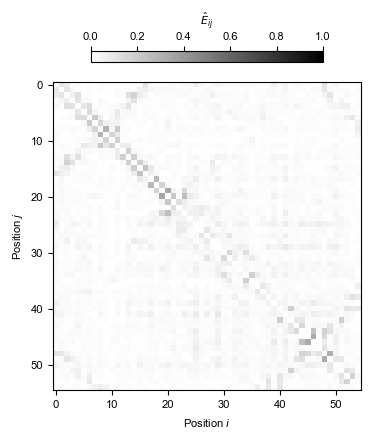

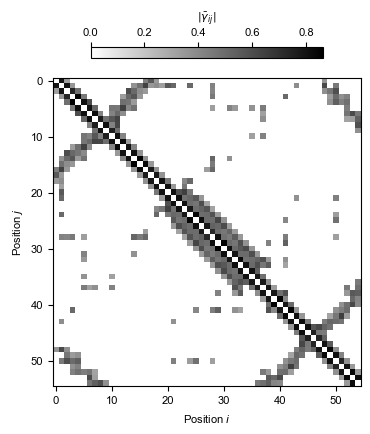

In [67]:
plt.rcParams["figure.figsize"] = (5,5)

fig, ax = plt.subplots ()

myh  = ax.imshow (avgT, cmap='gray_r', vmin=0, vmax=1)
cbar = plt.colorbar (myh, ax=ax, shrink=0.6, location='top')
cbar.set_label (  label=r'$\hat E_{ij}$', labelpad=5)
ax.set_xticks (np.arange (0, npos, 10))
ax.set_yticks (np.arange (0, npos, 10))
ax.set_ylabel ('Position $j$')
ax.set_xlabel ('Position $i$')
plt.show ()

plt.rcParams["figure.figsize"] = (5,5)

fig, ax = plt.subplots ()

myh = ax.imshow (np.abs (avgI), cmap='gray_r')

cbar = plt.colorbar (myh, ax=ax, shrink=0.6, location='top')
cbar.set_label (  label=r'$|\bar \gamma_{ij}|$', labelpad=5)
ax.set_xticks (np.arange (0, npos, 10))
ax.set_yticks (np.arange (0, npos, 10))
ax.set_ylabel ('Position $j$')
ax.set_xlabel ('Position $i$')
plt.show ()

In [68]:
Ep = np.zeros_like (avgT) * np.nan
for i in range (npos) :
    for j in range (i+1,npos) :
        nij = np.sum (~np.isnan (Pvals[i*nAA:(i*nAA + nAA),:][:,j*nAA:(j*nAA + nAA)]))
        oij = np.sum (Pvals[i*nAA:(i*nAA + nAA),:][:,j*nAA:(j*nAA + nAA)] < .1)
        Ep[i,j] = Ep[j,i] = 1. - scipy.stats.binom.cdf (oij, nij, p=alpha)

Ep[Ep == 0] = np.nanmin (Ep[Ep > 0])

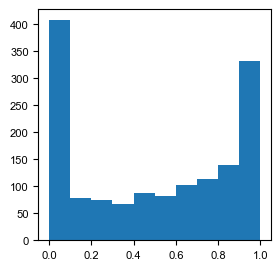

In [69]:
plt.rcParams["figure.figsize"] = (3,3)

plt.hist (Ep[np.triu_indices (npos, k=1)])
plt.show ()

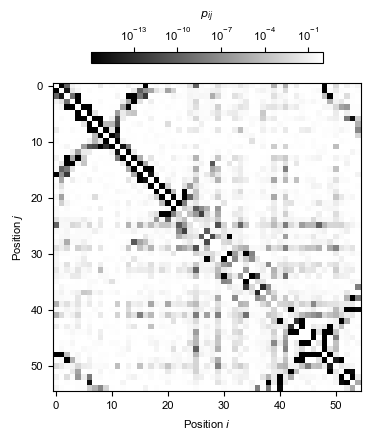

In [70]:
plt.rcParams["figure.figsize"] = (5,5)

fig, ax = plt.subplots ()

myh  = ax.imshow (Ep, cmap='gray', norm=mpl.colors.LogNorm ())
cbar = plt.colorbar (myh, ax=ax, shrink=0.6, location='top')
cbar.set_label (  label=r'$p_{ij}$', labelpad=5)
ax.set_xticks (np.arange (0, npos, 10))
ax.set_yticks (np.arange (0, npos, 10))
ax.set_ylabel ('Position $j$')
ax.set_xlabel ('Position $i$')
plt.show ()

In [71]:
# BH procedure
fdrps = scipy.stats.false_discovery_control (Ep[np.triu_indices (npos, k=1)], method='bh')

# back to matrix
FP = np.zeros_like (Ep)
FP[np.triu_indices (npos, k=1)] = fdrps
FP += np.transpose (FP)
np.fill_diagonal (FP, np.nan)

In [72]:
Dsign = np.zeros_like (Dmat)
Dsign[Dmat < 0] = -1
Dsign[Dmat > 0] = 1
Dsign[np.isnan (Dmat)] = np.nan

avgSign = np.zeros ((npos, npos)) * np.nan
for i in range (npos) :
    for j in range (i+1,npos) :
        avgSign[i,j] = avgSign[j,i] = np.nanmean (Dsign[i*nAA:(i*nAA + nAA),:][:,j*nAA:(j*nAA + nAA)])

# find contacts and nearby things
C5 = np.zeros_like (Df)
C8 = np.zeros_like (Df)

C5[np.logical_and (Df > 0, Df <= 5)] = 1
C8[np.logical_and (Df > 5, Df <= 8)] = 1

# plot all values with BH p-value <= .2
avgSign[FP > .1] = np.nan

maxval = np.nanmax (np.abs (avgSign))
ntests = np.sum (~np.isnan (Ep)) / 2
# spectral color map
spec = mpl.colormaps['Spectral']
norm = plt.Normalize(-maxval, maxval)

In [73]:
plt.rcParams["figure.figsize"] = (1.4,1.4)

fig, ax = plt.subplots ()

# plot nothing to set axes
Cnon = cp.deepcopy (C5)
Cnon[~np.isnan (C5)] = np.nan
ax.imshow (Cnon[pos_min:pos_max,:][:,pos_min:pos_max] )
    
# contact map
x, y = np.where ( C8[pos_min:pos_max,:][:,pos_min:pos_max] == 1 )
for i in range (len (x)) :
    ax.add_patch( Rectangle((y[i]-.5, x[i]-.5), 1, 1, fill=True,
                            color='lightgray', alpha=0.4, lw=.5))
x, y = np.where ( C5[pos_min:pos_max,:][:,pos_min:pos_max] == 1 )
for i in range (len (x)) :
    ax.add_patch( Rectangle((y[i]-.5, x[i]-.5), 1, 1, fill=True,
                            color='lightgray', lw=.5))
    
# plot "hits"
x, y = np.where (FP[pos_min:pos_max,:][:,pos_min:pos_max] <= .01)
ax.scatter (y, x, marker='o', edgecolor='black', linewidth=.5, color=spec( norm (avgSign[x, y])),
                 s=(-np.log10 (Ep[x,y]))*2, label=r'Bonf, $\alpha=10^{-1}$')
x, y = np.where ( np.logical_and (FP[pos_min:pos_max,:][:,pos_min:pos_max] > .01,
                                  FP[pos_min:pos_max,:][:,pos_min:pos_max] <= .1))
ax.scatter (y, x, marker='o',color=spec( norm (avgSign[x, y])),
                 s=(-np.log10 (Ep[x,y]))*2, label=r'Bonf, $\alpha=10^{-1}$')
    

# Create the figure
plt.xticks (np.arange (0, nvals, 2), np.arange (pos_min, pos_max, 2))
plt.yticks (np.arange (0, nvals, 2), np.arange (pos_min, pos_max, 2))
plt.xlabel ( r'Position $i$', labelpad=2 )
plt.ylabel ( r'Position $j$', labelpad=2 )

ax.tick_params (length=2)
ax.xaxis.set_tick_params (pad=1.5)
ax.yaxis.set_tick_params (pad=1.5)

# second legend
legend_elements = [Patch(facecolor='lightgray', linewidth=.5,
                         label=r'$\leq 5\AA$'),
                   Patch(facecolor='lightgray', alpha=0.4, edgecolor='black', linewidth=.5,
                         label=r'$\leq 8\AA$')]

if save :
    plt.savefig (os.path.join (outdir, 'fig2_g.svg'),
                 bbox_inches='tight', format='svg', transparent=True, dpi=600)
    plt.close ()
else :
    plt.show ()